# 📚 Unsupervised Learning and Novelty Detection (5 minutes)

### What is Unsupervised Learning?

**Unsupervised Learning** is a machine learning approach where we analyze data without labeled examples, seeking to discover hidden patterns, structures, or anomalies in the data.

### Key Components:

1. **Unlabeled Data**: Input data without target labels
2. **Pattern Discovery**: Finding hidden structures in data
3. **Anomaly Detection**: Identifying unusual or outlier patterns
4. **Dimensionality Reduction**: Learning compact representations
5. **Reconstruction**: Learning to recreate input data

### Our Novelty Detection Problem: 3W Oil Well Anomaly Detection

- **Objective**: Detect abnormal oil well operational states using only normal operation data
- **Training Data**: Only class 0 (normal operation) sensor measurements
- **Detection Target**: Identify when sensor patterns deviate from normal behavior
- **Challenge**: Learn normal patterns to detect any deviation as potential fault

### Why Novelty Detection Matters in Oil Wells:
- **Early Warning System**: Detect problems before they escalate
- **Unsupervised Monitoring**: No need for labeled fault examples
- **Operational Safety**: Continuous monitoring of normal vs abnormal states
- **Preventive Maintenance**: Identify subtle deviations before major failures

### Autoencoder-Based Novelty Detection Approach:
- **Training Phase**: Learn to reconstruct only normal operation patterns (class 0)
- **Detection Phase**: High reconstruction error indicates potential anomaly
- **Threshold**: Statistical approach (mean + 3×std) for anomaly scoring
- **Evaluation**: Test how well it distinguishes normal vs fault classes

### Problem Characteristics:
- **Normal-Only Training**: Learn patterns from class 0 data exclusively
- **Time Series**: Sequential sensor measurements requiring LSTM architecture
- **High Dimensional**: Many sensors × time steps = complex patterns
- **Reconstruction-Based**: Anomalies have higher reconstruction errors
- **Threshold-Based**: Statistical approach for anomaly detection

Let's explore LSTM autoencoders for oil well novelty detection!

#  Theory: Autoencoder Reconstruction Error for Anomaly Detection

##  What is an Autoencoder?

An **autoencoder** is a neural network designed to learn efficient representations of data through a reconstruction task. It consists of two main components:

### Architecture Components:
1. **Encoder**: Compresses input data into a lower-dimensional latent representation
2. **Decoder**: Reconstructs the original input from the latent representation
3. **Latent Space**: The compressed representation capturing essential patterns

```
Input → [Encoder] → Latent Space → [Decoder] → Reconstructed Output
```

##  Reconstruction Error Principle

### Core Concept:
The **reconstruction error** is the difference between the original input and the autoencoder's reconstruction attempt. This error serves as a powerful anomaly indicator.

### Mathematical Foundation:

**Reconstruction Error Formula:**
```
Error = ||x - x̂||²
```
Where:
- `x` = Original input
- `x̂` = Reconstructed output
- `||·||²` = Squared Euclidean norm (L2 norm)

### Why Reconstruction Error Works for Anomaly Detection:

1. **Normal Pattern Learning**: During training on normal data only, the autoencoder learns to efficiently encode and decode typical patterns
2. **Compression Efficiency**: Normal patterns are represented well in the latent space with low reconstruction error
3. **Anomaly Difficulty**: Anomalous patterns cannot be efficiently compressed using the learned normal representations
4. **Error Magnitude**: Higher reconstruction errors indicate data that doesn't fit the learned normal pattern

##  Anomaly Detection Process

### 1. Training Phase (Normal Data Only):
```python
# Train autoencoder on normal patterns
for normal_sample in normal_data:
    latent = encoder(normal_sample)
    reconstructed = decoder(latent)
    loss = mse(normal_sample, reconstructed)
    # Minimize reconstruction error for normal patterns
```

### 2. Threshold Determination:
- Calculate reconstruction errors on normal validation data
- Set threshold using statistical methods:
  - **Mean + k×σ**: `threshold = μ + k×σ` (typically k=2 or 3)
  - **Percentile-based**: 95th or 99th percentile of normal errors
  - **ROC optimization**: Threshold that maximizes true positive rate

### 3. Detection Phase:
```python
# Detect anomalies in new data
reconstruction_error = ||x_new - autoencoder(x_new)||²
is_anomaly = reconstruction_error > threshold
```

##  Statistical Foundation

### Normal Data Distribution:
- Reconstruction errors follow a **normal distribution** for typical data
- Low mean error with small variance
- Predictable error patterns

### Anomaly Characteristics:
- **Higher reconstruction errors** due to poor fit with learned patterns
- **Outlier behavior** in error distribution
- **Pattern deviation** from training distribution

### Performance Metrics:
1. **True Positive Rate (Sensitivity)**: Correctly detected anomalies
2. **False Positive Rate**: Normal data incorrectly flagged as anomalous
3. **AUC-ROC**: Area under receiver operating characteristic curve
4. **Precision/Recall**: Trade-off between detection accuracy and false alarms

### Industrial Advantages:

1. **Unsupervised Learning**: Only requires normal operation data (abundant)
2. **Real-time Detection**: Fast inference for continuous monitoring
3. **Adaptive Thresholds**: Can adjust to changing operational conditions
4. **Multivariate Analysis**: Considers relationships between multiple sensors
5. **Temporal Patterns**: LSTM autoencoders capture time-series dependencies



In [1]:
# ============================================================
# OPTIMIZED LOADING: 3W DATASET FOR UNSUPERVISED NOVELTY DETECTION
# ============================================================
import time

start_time = time.time()

print("Loading 3W Dataset for Autoencoder Novelty Detection")
print("=" * 60)

# Import data loading utilities
import sys
import os

sys.path.append("src")

print("Importing modules...", end=" ")
from src.data_persistence import DataPersistence
from src import config
import pandas as pd
import numpy as np

print(" ")

# ============================================================
# OPTIMIZATION SETTINGS - ADJUSTED FOR BETTER CLASS COVERAGE
# ============================================================
USE_SINGLE_FOLD = (
    False  # True: Fast loading (one fold), False: Complete dataset (all folds)
)
TARGET_FOLD = "fold_1"  # Which fold to use for single fold loading
MAX_NORMAL_SAMPLES = 2000  # Limit normal samples for faster processing
MAX_ANOMALY_SAMPLES = 1000  # Increased limit for better class coverage
ENABLE_SAMPLING = True  # True: Apply sampling limits, False: Load all available data

# ============================================================
# ANOMALY CLASS CONFIGURATION: ONLY CLASSES 3, 4, 8
# ============================================================
SELECTED_ANOMALY_CLASSES = [3, 4, 8]  # Only use these classes as anomalies
print(f"Anomaly Class Configuration: {SELECTED_ANOMALY_CLASSES}")

print(f"Optimization Settings:")
print(f"   • Single fold loading: {USE_SINGLE_FOLD}")
if USE_SINGLE_FOLD:
    print(f"   • Target fold: {TARGET_FOLD}")
print(f"   • Sampling enabled: {ENABLE_SAMPLING}")
if ENABLE_SAMPLING:
    print(f"   • Max normal samples: {MAX_NORMAL_SAMPLES}")
    print(f"   • Max anomaly samples: {MAX_ANOMALY_SAMPLES}")
print(f"   • Selected anomaly classes: {SELECTED_ANOMALY_CLASSES}")

try:
    print(f"\nInitializing data persistence...", end=" ")
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    print(" ")

    print(f"Using format: {config.SAVE_FORMAT}")

    # Check if windowed directory exists
    windowed_dir = os.path.join(persistence.cv_splits_dir, "windowed")
    print(f"Checking windowed directory: {windowed_dir}...", end=" ")

    if not os.path.exists(windowed_dir):
        print(" ")
        print(
            "  No windowed data directory found. Please run Data Treatment notebook first to generate windowed time series data."
        )
        raise FileNotFoundError("Windowed data directory not found")
    else:
        print(" ")

        # Look for fold directories
        print("Looking for fold directories...", end=" ")
        fold_dirs = [
            d
            for d in os.listdir(windowed_dir)
            if d.startswith("fold_") and os.path.isdir(os.path.join(windowed_dir, d))
        ]
        fold_dirs.sort()
        print(f"  Found {len(fold_dirs)} folds: {fold_dirs}")

        if not fold_dirs:
            print("  No fold directories found in windowed data.")
            raise FileNotFoundError("No fold directories found")

        # Determine which folds to process
        if USE_SINGLE_FOLD:
            if TARGET_FOLD in fold_dirs:
                process_folds = [TARGET_FOLD]
                print(f"Using single fold: {TARGET_FOLD}")
            else:
                process_folds = [fold_dirs[0]]  # Use first available fold
                print(
                    f"⚠️ Target fold '{TARGET_FOLD}' not found, using: {process_folds[0]}"
                )
        else:
            process_folds = fold_dirs
            print(f"Using all {len(fold_dirs)} folds for better class coverage")

        # Separate data containers for normal (class 0) and anomaly (selected classes only) data
        normal_windows = []  # Class 0 for autoencoder training (ALL normal data)
        normal_classes = []
        anomaly_windows = []  # Only selected classes for anomaly testing (ALL anomaly data)
        anomaly_classes = []
        
        # Track class distribution during loading
        class_counts = {str(cls): 0 for cls in SELECTED_ANOMALY_CLASSES}
        class_counts['0'] = 0  # Normal class

        load_start = time.time()
        total_files_processed = 0

        for fold_idx, fold_name in enumerate(process_folds):
            fold_path = os.path.join(windowed_dir, fold_name)

            print(
                f"\nProcessing {fold_name} ({fold_idx + 1}/{len(process_folds)})..."
            )

            # MODIFIED: Merge train and test data from each fold, then separate by class
            print(f"   Loading and merging train+test data...", end=" ")
            
            all_fold_dfs = []
            all_fold_classes = []

            # Load both train and test data
            for data_type in ["train", "test"]:
                # Try pickle first, then parquet
                pickle_file = os.path.join(
                    fold_path, f"{data_type}_windowed.{config.SAVE_FORMAT}"
                )
                parquet_file = os.path.join(fold_path, f"{data_type}_windowed.parquet")

                fold_dfs, fold_classes = [], []

                if os.path.exists(pickle_file):
                    try:
                        fold_dfs, fold_classes = persistence._load_dataframes(
                            pickle_file, config.SAVE_FORMAT
                        )
                        print(f"  {data_type}({len(fold_dfs)})", end="")
                        total_files_processed += 1
                    except Exception as e:
                        print(f"  {data_type}(pickle error)", end="")
                        # Try parquet as fallback
                        if os.path.exists(parquet_file):
                            try:
                                fold_dfs, fold_classes = persistence._load_from_parquet(
                                    parquet_file
                                )
                                print(f"  {data_type}({len(fold_dfs)} parquet)", end="")
                                total_files_processed += 1
                            except Exception as e2:
                                print(f"  {data_type}(failed)", end="")

                elif os.path.exists(parquet_file):
                    try:
                        fold_dfs, fold_classes = persistence._load_from_parquet(
                            parquet_file
                        )
                        print(f"  {data_type}({len(fold_dfs)})", end="")
                        total_files_processed += 1
                    except Exception as e:
                        print(f"  {data_type}(error)", end="")
                else:
                    print(f"  {data_type}(not found)", end="")

                # Add to merged fold data
                all_fold_dfs.extend(fold_dfs)
                all_fold_classes.extend(fold_classes)

            print(f"  -> Total: {len(all_fold_dfs)} windows")

            # Now separate the merged data by class (normal vs selected anomalies)
            for df, cls in zip(all_fold_dfs, all_fold_classes):
                cls_str = str(cls)
                
                if cls_str == "0":  # Normal operation - USE ALL FOR TRAINING
                    if (
                        not ENABLE_SAMPLING
                        or len(normal_windows) < MAX_NORMAL_SAMPLES
                    ):
                        normal_windows.append(df)
                        normal_classes.append(cls)
                        class_counts['0'] += 1
                elif int(cls) in SELECTED_ANOMALY_CLASSES:  # Only selected fault classes - USE ALL FOR TESTING
                    # Use per-class sampling to ensure balanced representation
                    current_class_count = class_counts.get(cls_str, 0)
                    max_per_class = MAX_ANOMALY_SAMPLES // len(SELECTED_ANOMALY_CLASSES)
                    
                    if (
                        not ENABLE_SAMPLING
                        or current_class_count < max_per_class
                    ):
                        anomaly_windows.append(df)
                        anomaly_classes.append(cls)
                        class_counts[cls_str] += 1

            # Show progress with class distribution
            if ENABLE_SAMPLING:
                print(f"      Running totals: Normal: {class_counts['0']}")
                for cls in SELECTED_ANOMALY_CLASSES:
                    cls_str = str(cls)
                    print(f"                      Class {cls}: {class_counts.get(cls_str, 0)}")

        load_time = time.time() - load_start

        if normal_windows and anomaly_windows:
            print(f"\n  Successfully loaded and separated windowed data!")
            print(f"Normal operation windows (class 0): {len(normal_windows)} -> ALL FOR TRAINING")
            print(f"Anomaly windows (classes {SELECTED_ANOMALY_CLASSES}): {len(anomaly_windows)} -> ALL FOR TESTING")
            print(f"Loading time: {load_time:.3f} seconds")
            print(f"Files processed: {total_files_processed}")

            # Display sample window information
            if normal_windows:
                print("\nProcessing sample windows...", end=" ")
                first_normal_window = normal_windows[0]
                print("")

                print(f"\nSample Normal Window (Window #1):")
                print(f"   • Shape: {first_normal_window.shape}")
                print(f"   • Class: {normal_classes[0]} (Normal Operation)")
                print(f"   • Features: {list(first_normal_window.columns)}")

                # Show class distribution
                print(f"\nData Split Strategy for Unsupervised Learning:")
                print(f"   • Normal data (Class 0): {len(normal_windows)} windows -> TRAINING")
                print(f"   • Usage: Train autoencoder to learn normal patterns")

                print(f"\nDetailed Anomaly Class Distribution:")
                anomaly_unique, anomaly_counts = np.unique(
                    anomaly_classes, return_counts=True
                )
                for cls, count in zip(anomaly_unique, anomaly_counts):
                    print(f"   • Class {cls}: {count} windows -> TESTING")
                print(f"   • Total anomaly windows: {len(anomaly_windows)} -> TESTING")
                print(f"   • Usage: Evaluate anomaly detection performance")
                
                # Check for missing classes
                expected_classes = set(str(cls) for cls in SELECTED_ANOMALY_CLASSES)
                found_classes = set(str(cls) for cls in anomaly_unique)
                missing_classes = expected_classes - found_classes
                
                if missing_classes:
                    print(f"\n⚠️ Warning: Expected classes missing from loaded data: {sorted(missing_classes)}")
                    print(f"   • This could be due to:")
                    print(f"     - Classes not present in the selected folds")
                    print(f"     - Very few samples available for those classes")
                    print(f"   • Consider:")
                    print(f"     - Setting USE_SINGLE_FOLD = False to use all folds")
                    print(f"     - Increasing MAX_ANOMALY_SAMPLES")
                    print(f"     - Checking if those classes exist in the dataset")
                else:
                    print(f"\n✅ All expected anomaly classes found in the data!")

                total_time = time.time() - start_time
                print(f"\nPerformance Summary:")
                print(f"   • Total execution time: {total_time:.3f} seconds")
                print(f"   • Data loading time: {load_time:.3f} seconds")
                print(f"   • File format: {config.SAVE_FORMAT}")
                print(f"   • Folds processed: {len(process_folds)}")

                print(f"\nDataset Summary for Novelty Detection:")
                print(f"   • Normal training data: {len(normal_windows)} windows (merged train+test)")
                print(f"   • Anomaly test data: {len(anomaly_windows)} windows (merged train+test)")
                print(f"   • Window dimensions: {first_normal_window.shape}")
                print(f"   • Selected anomaly classes: {sorted(anomaly_unique)}")

                if ENABLE_SAMPLING:
                    print(f"\nConfiguration Notes:")
                    print(f"   • Sampling enabled for faster processing")
                    print(f"   • Only classes {SELECTED_ANOMALY_CLASSES} used as anomalies")
                    print(f"   • Train/test data merged per fold, then split by class")
                    print(f"   • ALL normal data used for training (no validation split)")
                    print(f"   • ALL anomaly data used for testing")
                    print(f"   • To use full dataset: Set ENABLE_SAMPLING = False")
                    print(f"   • To use all folds: Set USE_SINGLE_FOLD = False")

            else:
                print("⚠️ No normal operation windows found")

        else:
            print("⚠️ Insufficient data found for novelty detection")
            print(f"   • Normal windows: {len(normal_windows)}")
            print(f"   • Anomaly windows: {len(anomaly_windows)}")
            normal_windows = []
            normal_classes = []
            anomaly_windows = []
            anomaly_classes = []

except Exception as e:
    print(f"\n  Error loading data: {str(e)}")
    print(f"\nTroubleshooting:")
    print(f"   1. Make sure 'Data Treatment.ipynb' ran completely")
    print(f"   2. Check if windowed data was saved successfully")
    print(f"   3. Verify the processed_data directory exists")
    print(f"   4. Check if pickle files are corrupted")
    print(f"   5. Try using parquet format instead")

    # Show detailed error information
    import traceback

    print(f"\nDetailed error information:")
    print(traceback.format_exc())

    # Initialize empty variables for error case
    normal_windows = []
    normal_classes = []
    anomaly_windows = []
    anomaly_classes = []

Loading 3W Dataset for Autoencoder Novelty Detection
Importing modules...  
Anomaly Class Configuration: [3, 4, 8]
Optimization Settings:
   • Single fold loading: False
   • Sampling enabled: True
   • Max normal samples: 2000
   • Max anomaly samples: 1000
   • Selected anomaly classes: [3, 4, 8]

Initializing data persistence...  
Using format: pickle
Checking windowed directory: processed_data\cv_splits\windowed...  
Looking for fold directories...   Found 3 folds: ['fold_1', 'fold_2', 'fold_3']
Using all 3 folds for better class coverage

Processing fold_1 (1/3)...
   Loading and merging train+test data...  
Anomaly Class Configuration: [3, 4, 8]
Optimization Settings:
   • Single fold loading: False
   • Sampling enabled: True
   • Max normal samples: 2000
   • Max anomaly samples: 1000
   • Selected anomaly classes: [3, 4, 8]

Initializing data persistence...  
Using format: pickle
Checking windowed directory: processed_data\cv_splits\windowed...  
Looking for fold directories..

In [2]:
# ============================================================
# IMPORT REQUIRED LIBRARIES AND MODULES
# ============================================================

print("LSTM Autoencoder for Anomaly Detection")
print("=" * 45)

# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Import our custom modules
from src.autoencoder_models import StableLSTMAutoencoder
from src.unsupervised_preprocessing import UnsupervisedDataPreprocessor
from src.anomaly_detection import AnomalyDetector, visualize_latent_space

# Set TensorFlow to avoid NaN issues
tf.config.run_functions_eagerly(False)

# Check if we have loaded data from previous cell
if (
    "normal_windows" in locals()
    and normal_windows is not None
    and len(normal_windows) > 0
    and "anomaly_windows" in locals()
    and anomaly_windows is not None
    and len(anomaly_windows) > 0
):

    print("  Data available for processing")
    print(f"Normal operation windows: {len(normal_windows)}")
    print(f"Anomaly windows: {len(anomaly_windows)}")
    data_ready = True

else:
    print(
        "  No data available. Please run the previous cell first to load normal and anomaly data."
    )
    data_ready = False

LSTM Autoencoder for Anomaly Detection
  Data available for processing
Normal operation windows: 2000
Anomaly windows: 999


##  Modular LSTM Autoencoder Implementation

This section implements a **stable LSTM autoencoder** for anomaly detection using a **modular approach**. The code has been organized into reusable components in the `src/` directory:

###  New Modules Created:

1. **`autoencoder_models.py`** - Contains the `StableLSTMAutoencoder` class with:
   - Stable architecture with gradient clipping
   - Conservative hyperparameters for numerical stability
   - Built-in training and prediction methods

2. **`unsupervised_preprocessing.py`** - Contains the `UnsupervisedDataPreprocessor` class with:
   - Smart data sampling for training efficiency
   - Robust data validation and conversion
   - Numerical stability enhancements

3. **`anomaly_detection.py`** - Contains the `AnomalyDetector` class with:
   - Reconstruction error computation
   - Threshold determination methods
   - Performance evaluation and visualization

###  Benefits of This Approach:

- **Modularity**: Each component has a single responsibility
- **Reusability**: Classes can be used in other projects
- **Maintainability**: Easier to debug and modify individual components
- **Stability**: Enhanced numerical safeguards and error handling
- **Clarity**: Notebook cells are focused and easier to understand

###  Usage Pattern:

The following cells demonstrate the complete pipeline from data preprocessing through model training to anomaly detection evaluation.

In [3]:
# ============================================================
# DATA PREPROCESSING AND SAMPLING
# ============================================================

if data_ready:
    print("Data Preprocessing Pipeline")
    print("=" * 35)

    # Initialize data preprocessor with conservative settings for stability
    preprocessor = UnsupervisedDataPreprocessor(
        max_training_samples=1000,  # Reduced for stability
        max_anomaly_samples=300,  # Reduced for stability
        random_seed=42,
    )

    # Run the complete preprocessing pipeline with anomaly class information
    normal_scaled, anomaly_scaled, data_info, processed_anomaly_classes = preprocessor.prepare_full_pipeline(
        normal_windows, anomaly_windows, anomaly_classes
    )

    print(f"\n  Data preprocessing completed successfully!")
    print(f"Final Configuration:")
    print(f"   • Time steps per window: {data_info['time_steps']}")
    print(
        f"   • Features per time step: {data_info['n_features']} (class column removed)"
    )
    print(f"   • Normal training samples: {data_info['n_normal_samples']}")
    print(f"   • Anomaly test samples: {data_info['n_anomaly_samples']}")
    
    # Show final anomaly class distribution after preprocessing
    if processed_anomaly_classes is not None:
        from collections import Counter
        final_class_dist = Counter(str(cls) for cls in processed_anomaly_classes)
        print(f"   • Final anomaly class distribution: {dict(final_class_dist)}")
        
        # Update global anomaly_classes to match processed data
        anomaly_classes = processed_anomaly_classes
    else:
        print(f"   • No anomaly class information available")

    preprocessing_complete = True

else:
    print("  Cannot proceed with preprocessing - no data available")
    preprocessing_complete = False

Data Preprocessing Pipeline
🔧 Complete Data Preparation Pipeline
⚡ Smart Data Sampling for Training Efficiency
🎯 Training optimization settings:
   • Max normal samples for training: 1000
   • Max anomaly samples for testing: 300
📊 Sampling 1000 normal windows from 2000 available...
📊 Balanced sampling 300 anomaly windows from 999 available...
   • Target samples per class: 100
   • Class 3: 100 samples selected from 333 available
   • Class 4: 100 samples selected from 333 available
   • Class 8: 100 samples selected from 333 available

✅ Sampling complete:
   • Normal windows: 1000
   • Anomaly windows: 300
   • Anomaly class distribution: {'3': 100, '4': 100, '8': 100}
📊 Converting normal windows to arrays... ✅ (1000 valid processed)
📊 Converting anomaly windows to arrays... ✅ (300 valid processed)
🔍 Validating array shapes and data quality...
Expected shape: (300, 3)
✅ Valid arrays: 1000 normal, 300 anomaly
📊 Data quality checks:
   • Normal data range: [0.000, 1.000]
   • Anomaly 

In [4]:
# ============================================================
# BUILD AND TRAIN LSTM AUTOENCODER
# ============================================================

if preprocessing_complete:
    print("Building and Training LSTM Autoencoder")
    print("=" * 45)

    # Initialize the autoencoder with conservative parameters for stability
    autoencoder = StableLSTMAutoencoder(
        time_steps=data_info["time_steps"],
        n_features=data_info["n_features"],
        latent_dim=16,  # Conservative for stability
        lstm_units=64,  # Conservative for stability
    )

    # Build the model
    model = autoencoder.build_model()

    # MODIFIED: Use ALL normal data for training (no train/validation split)
    # In unsupervised novelty detection:
    # - ALL normal data is used for training the autoencoder
    # - ALL anomaly data is used for testing/evaluation
    print(f"\nTraining Data Configuration:")
    print(f"   • Training samples: {len(normal_scaled)} (ALL normal data)")
    print(f"   • No validation split - using ALL normal data for training")
    print(f"   • Anomaly data will be used purely for testing")

    # Use all normal data for training
    train_normal = normal_scaled
    
    print(f"\nUnsupervised Learning Strategy:")
    print(f"   • Train autoencoder ONLY on normal operation patterns")
    print(f"   • Learn to reconstruct normal behavior with low error")
    print(f"   • High reconstruction error indicates anomalous patterns")

    # Train the autoencoder
    print(f"\nStarting Training...")
    training_start = time.time()

    # MODIFIED: No validation data since we use all normal data for training
    # The autoencoder will learn to reconstruct normal patterns only
    training_success = autoencoder.train(
        train_data=train_normal,
        val_data=None,  # No validation split - use all normal data for training
        epochs=30,  # Conservative for stability
        batch_size=32,  # Conservative for stability
        verbose=1,
    )

    training_time = time.time() - training_start
    print(f"\nTraining completed in {training_time:.2f} seconds")

    if training_success:
        print("  Model trained successfully on normal operation data")
        print("  Ready to detect anomalies based on reconstruction error")
        model_ready = True
    else:
        print("  Training failed - check for numerical stability issues")
        model_ready = False

else:
    print("  Cannot build model - preprocessing not completed")
    model_ready = False

Building and Training LSTM Autoencoder
🏗️ Building Stable LSTM Autoencoder:
   • Input shape: (300, 3)
   • Encoder LSTM units: 64
   • Latent dimension: 16
   • Decoder LSTM units: 64


✅ Stable LSTM Autoencoder model created
   • Total parameters: 39,379
   • Gradient clipping enabled (clipnorm=1.0)
   • Conservative learning rate (0.0005)

Training Data Configuration:
   • Training samples: 1000 (ALL normal data)
   • No validation split - using ALL normal data for training
   • Anomaly data will be used purely for testing

Unsupervised Learning Strategy:
   • Train autoencoder ONLY on normal operation patterns
   • Learn to reconstruct normal behavior with low error
   • High reconstruction error indicates anomalous patterns

Starting Training...
🚂 Training LSTM Autoencoder:
   • Training samples: 1000
   • No validation data - using all data for training
   • Max epochs: 30
   • Batch size: 32
Epoch 1/30
✅ Stable LSTM Autoencoder model created
   • Total parameters: 39,379
   • Gr

  Training History Visualization


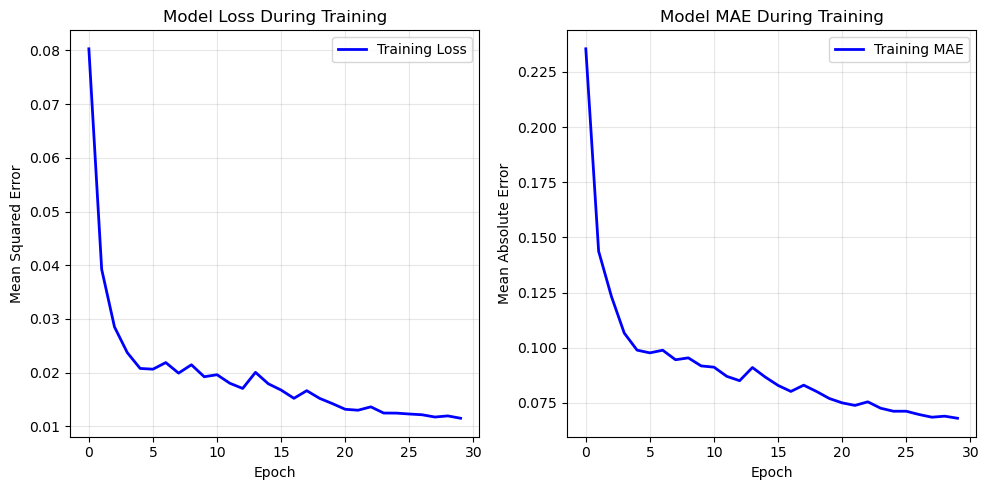


  Training Summary:
   • Epochs trained: 30
   • Final training loss: 0.011533
   • Training time: 172.48 seconds
   • No validation data used - trained on ALL normal data
   • Model learned to reconstruct normal operation patterns
   • Ready for anomaly detection based on reconstruction error


In [5]:
# ============================================================
# TRAINING VISUALIZATION
# ============================================================

if model_ready and autoencoder.history is not None:
    print("  Training History Visualization")
    print("=" * 35)

    history = autoencoder.history.history

    # Determine if we have validation data
    has_validation = 'val_loss' in history

    # Create training plots - adjust based on available data
    if has_validation:
        plt.figure(figsize=(15, 5))
        subplot_count = 3
    else:
        plt.figure(figsize=(10, 5))
        subplot_count = 2

    # Loss plot
    plt.subplot(1, subplot_count, 1)
    plt.plot(history["loss"], label="Training Loss", linewidth=2, color="blue")
    if has_validation:
        plt.plot(history["val_loss"], label="Validation Loss", linewidth=2, color="orange")
    plt.title("Model Loss During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # MAE plot
    plt.subplot(1, subplot_count, 2)
    plt.plot(history["mae"], label="Training MAE", linewidth=2, color="blue")
    if has_validation:
        plt.plot(history["val_mae"], label="Validation MAE", linewidth=2, color="orange")
    plt.title("Model MAE During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning rate plot (if available) - only show if we have validation data
    if has_validation:
        plt.subplot(1, 3, 3)
        if "lr" in history:
            plt.plot(history["lr"], label="Learning Rate", linewidth=2, color="green")
            plt.title("Learning Rate Schedule")
            plt.xlabel("Epoch")
            plt.ylabel("Learning Rate")
            plt.yscale("log")
        else:
            plt.text(
                0.5,
                0.5,
                "Learning Rate\nHistory\nNot Available",
                ha="center",
                va="center",
                transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round", facecolor="lightgray"),
            )
            plt.title("Learning Rate Schedule")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print training summary
    final_train_loss = history["loss"][-1]
    epochs_trained = len(history["loss"])

    print(f"\n  Training Summary:")
    print(f"   • Epochs trained: {epochs_trained}")
    print(f"   • Final training loss: {final_train_loss:.6f}")
    print(f"   • Training time: {training_time:.2f} seconds")
    
    if has_validation:
        final_val_loss = history["val_loss"][-1]
        print(f"   • Final validation loss: {final_val_loss:.6f}")
        
        if final_val_loss < final_train_loss * 1.5:
            print("     No significant overfitting detected")
        else:
            print("    Possible overfitting - validation loss higher than expected")
    else:
        print("   • No validation data used - trained on ALL normal data")
        print("   • Model learned to reconstruct normal operation patterns")
        print("   • Ready for anomaly detection based on reconstruction error")

else:
    print("  No training history available for visualization")

In [6]:
# ============================================================
# ANOMALY DETECTION AND PER-CLASS EVALUATION
# ============================================================

if model_ready:
    print("🔍 Anomaly Detection and Per-Class Evaluation")
    print("=" * 45)

    # Initialize anomaly detector
    detector = AnomalyDetector()

    # Compute reconstruction errors
    normal_errors, anomaly_errors = detector.compute_reconstruction_errors(
        autoencoder=autoencoder, normal_data=normal_scaled, anomaly_data=anomaly_scaled
    )

    # Determine threshold using 95th percentile of normal errors
    threshold = detector.determine_threshold(method="percentile", percentile=95)

    # Evaluate detection performance
    metrics = detector.evaluate_detection()

    # Calculate our own metrics if they're missing from detector
    if normal_errors is not None and anomaly_errors is not None:
        normal_detected = np.sum(np.array(normal_errors) > threshold)
        anomaly_detected = np.sum(np.array(anomaly_errors) > threshold)
        
        normal_accuracy = 1 - (normal_detected / len(normal_errors))  # Correctly classified as normal
        anomaly_accuracy = anomaly_detected / len(anomaly_errors)     # Correctly classified as anomaly
        overall_accuracy = ((len(normal_errors) - normal_detected) + anomaly_detected) / (len(normal_errors) + len(anomaly_errors))
        
        # Ensure we have the required metrics
        if 'normal_accuracy' not in metrics:
            metrics['normal_accuracy'] = normal_accuracy
        if 'anomaly_accuracy' not in metrics:
            metrics['anomaly_accuracy'] = anomaly_accuracy
        if 'overall_accuracy' not in metrics:
            metrics['overall_accuracy'] = overall_accuracy

    print(f"\n🎯 Overall Anomaly Detection Results:")
    print(f"   • Threshold: {threshold:.6f}")
    print(f"   • Normal accuracy: {metrics['normal_accuracy']:.3f}")
    print(f"   • Anomaly accuracy: {metrics['anomaly_accuracy']:.3f}")
    print(f"   • Overall accuracy: {metrics['overall_accuracy']:.3f}")

    # ============================================================
    # PER-ANOMALY CLASS ANALYSIS WITH FIXED INDEXING
    # ============================================================
    
    print(f"\n📊 Per-Anomaly Class Detection Performance:")
    print("=" * 50)
    
    # Debug: Check what classes we actually have
    print(f"Debug Info:")
    print(f"   • Total anomaly samples: {len(anomaly_classes)}")
    print(f"   • Expected classes: {SELECTED_ANOMALY_CLASSES}")
    print(f"   • Actual classes in data: {sorted(set(str(cls) for cls in anomaly_classes))}")
    print(f"   • Class distribution: {dict(zip(*np.unique(anomaly_classes, return_counts=True)))}")
    print(f"   • Anomaly errors length: {len(anomaly_errors)}")
    print(f"   • Anomaly classes length: {len(anomaly_classes)}")
    
    # Verify the lengths match
    if len(anomaly_errors) != len(anomaly_classes):
        print(f"   ⚠️ CRITICAL: Length mismatch between errors and classes!")
        print(f"      Truncating to minimum length for safety...")
        min_length = min(len(anomaly_errors), len(anomaly_classes))
        anomaly_errors = anomaly_errors[:min_length]
        anomaly_classes = anomaly_classes[:min_length]
    
    # Get unique anomaly classes
    from collections import defaultdict
    import numpy as np
    
    anomaly_class_errors = defaultdict(list)
    anomaly_class_indices = defaultdict(list)
    
    # Group errors by anomaly class - FIXED: ensure proper data type handling
    print(f"\nGrouping errors by class...")
    for i, (error, cls) in enumerate(zip(anomaly_errors, anomaly_classes)):
        # Ensure consistent data type conversion
        if isinstance(cls, (np.integer, int)):
            cls_str = str(int(cls))  # Convert numpy int to python int to string
        else:
            cls_str = str(cls)
        
        anomaly_class_errors[cls_str].append(float(error))  # Ensure error is float
        anomaly_class_indices[cls_str].append(i)
        
        # Debug: Show first few mappings
        if i < 5:
            print(f"   Sample {i}: class={cls_str}, error={error:.6f}")
    
    print(f"\nClasses found in error analysis: {sorted(anomaly_class_errors.keys())}")
    print(f"Class counts from error analysis:")
    for cls, errors in sorted(anomaly_class_errors.items()):
        print(f"   • Class {cls}: {len(errors)} samples")
    
    # Calculate per-class metrics
    per_class_metrics = {}
    anomaly_class_colors = {}
    
    # Define colors for different anomaly classes
    colors = ['red', 'orange', 'brown', 'pink', 'purple', 'olive', 'cyan', 'magenta', 'yellow']
    
    print(f"\n{'Class':<8} {'Count':<8} {'Mean Error':<12} {'Std Error':<12} {'Accuracy':<10} {'Color':<10}")
    print("-" * 70)
    
    for i, (cls, errors) in enumerate(sorted(anomaly_class_errors.items())):
        errors_array = np.array(errors)
        mean_error = np.mean(errors_array)
        std_error = np.std(errors_array)
        
        # Calculate accuracy for this class (how many exceed threshold)
        detected = np.sum(errors_array > threshold)
        accuracy = detected / len(errors_array)
        
        # Assign color
        color = colors[i % len(colors)]
        anomaly_class_colors[cls] = color
        
        per_class_metrics[cls] = {
            'count': len(errors_array),
            'mean_error': mean_error,
            'std_error': std_error,
            'accuracy': accuracy,
            'color': color,
            'indices': anomaly_class_indices[cls]
        }
        
        print(f"{cls:<8} {len(errors_array):<8} {mean_error:<12.6f} {std_error:<12.6f} {accuracy:<10.3f} {color:<10}")
    
    # Check if we have all expected classes
    expected_classes = set(str(cls) for cls in SELECTED_ANOMALY_CLASSES)
    found_classes = set(anomaly_class_errors.keys())
    missing_classes = expected_classes - found_classes
    
    if missing_classes:
        print(f"\n⚠️ Warning: Expected classes missing from error analysis: {missing_classes}")
        print(f"   This could happen if:")
        print(f"   1. Data type conversion issues between loading and processing")
        print(f"   2. Indexing misalignment between errors and class labels")
        print(f"   3. Sampling or filtering removed those classes")
        
        # Additional debugging
        print(f"\nAdditional Debug Info:")
        print(f"   • Original anomaly_classes types: {[type(cls).__name__ for cls in anomaly_classes[:5]]}")
        print(f"   • Sample anomaly_classes values: {anomaly_classes[:10]}")
        print(f"   • Expected classes (as strings): {expected_classes}")
        print(f"   • Found classes: {found_classes}")
    else:
        print(f"\n✅ All expected anomaly classes found in the error analysis!")
    
    if per_class_metrics:
        # Summary statistics
        print(f"\n📈 Detection Performance Summary:")
        best_detected = max(per_class_metrics.items(), key=lambda x: x[1]['accuracy'])
        worst_detected = min(per_class_metrics.items(), key=lambda x: x[1]['accuracy'])
        
        print(f"   • Best detected class: {best_detected[0]} ({best_detected[1]['accuracy']:.3f} accuracy)")
        print(f"   • Worst detected class: {worst_detected[0]} ({worst_detected[1]['accuracy']:.3f} accuracy)")
        
        # Calculate average error per class vs normal
        normal_mean_error = np.mean(normal_errors)
        print(f"   • Normal operation mean error: {normal_mean_error:.6f}")
        
        print(f"\n📊 Error Amplification by Class:")
        for cls, metrics_data in sorted(per_class_metrics.items()):
            amplification = metrics_data['mean_error'] / normal_mean_error
            print(f"   • Class {cls}: {amplification:.2f}x higher than normal")

        detection_complete = True
        
        # Store per-class info for visualization
        globals()['per_class_metrics'] = per_class_metrics
        globals()['anomaly_class_colors'] = anomaly_class_colors
    else:
        print(f"\n❌ No per-class metrics could be calculated!")
        print(f"   Check data loading and class filtering logic.")
        detection_complete = False

else:
    print("  Cannot perform anomaly detection - model not ready")
    detection_complete = False

🔍 Anomaly Detection and Per-Class Evaluation
📊 Computing Reconstruction Errors
🔵 Computing reconstruction errors for normal data...
🔴 Computing reconstruction errors for anomaly data...
🔴 Computing reconstruction errors for anomaly data...
✅ Reconstruction errors computed:
   • Normal errors: 1000 samples
   • Anomaly errors: 300 samples
   • Normal error range: [0.000275, 0.123773]
   • Anomaly error range: [0.000500, 0.349652]
🎯 Determining Anomaly Threshold (percentile)
📈 Threshold set at 95th percentile: 0.017747
📊 Evaluating Anomaly Detection Performance
🎯 Detection Results:
   • Threshold: 0.017747
   • Normal data accuracy: 0.950 (950/1000)
   • Anomaly data accuracy: 0.613 (184/300)
   • Overall accuracy: 0.872
   • False positives (normal as anomaly): 50
   • False negatives (anomaly as normal): 116

🎯 Overall Anomaly Detection Results:
   • Threshold: 0.017747
   • Normal accuracy: 0.950
   • Anomaly accuracy: 0.613
   • Overall accuracy: 0.872

📊 Per-Anomaly Class Detection 

📈 Comprehensive Results Visualization with Per-Class Analysis


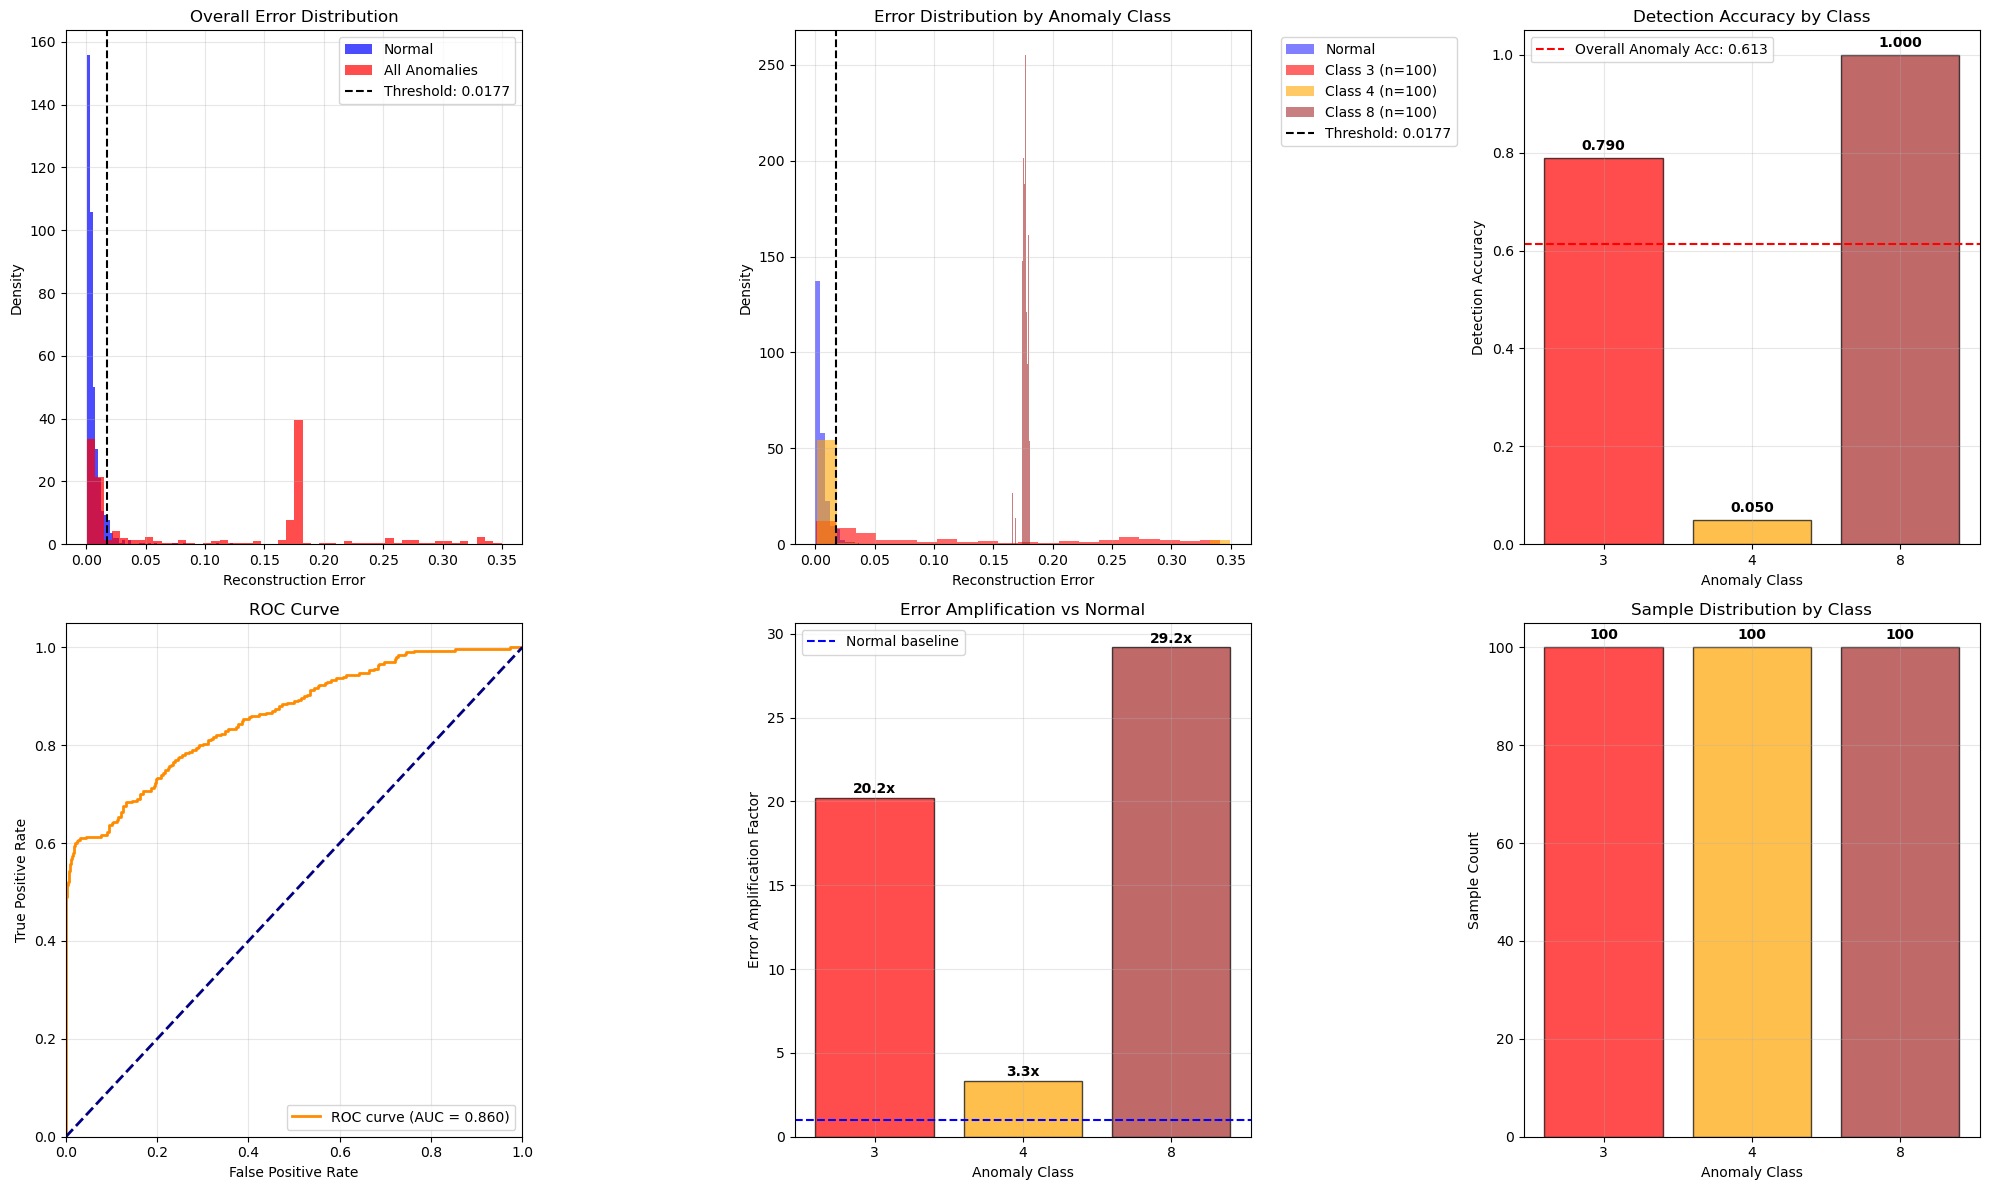


📊 Comprehensive Analysis Summary:
   • Overall ROC AUC: 0.860
   • Total normal samples: 1000
   • Total anomaly samples: 300
   • Number of anomaly classes found: 3
   • Expected anomaly classes: [3, 4, 8]
   • Found anomaly classes: ['3', '4', '8']
   • High-performing classes (>80% accuracy): ['8']
   • Low-performing classes (<50% accuracy): ['4']
   🎉 Excellent overall anomaly detection performance!


In [7]:
# ============================================================
# ENHANCED RESULTS VISUALIZATION WITH PER-CLASS ANALYSIS
# ============================================================

if detection_complete and 'per_class_metrics' in globals() and per_class_metrics:
    print("📈 Comprehensive Results Visualization with Per-Class Analysis")
    print("=" * 65)

    # Create enhanced visualization with per-class breakdown
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Overall error distributions
    axes[0, 0].hist(normal_errors, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    axes[0, 0].hist(anomaly_errors, bins=50, alpha=0.7, label='All Anomalies', color='red', density=True)
    axes[0, 0].axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')
    axes[0, 0].set_xlabel('Reconstruction Error')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Overall Error Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Per-class error distributions
    axes[0, 1].hist(normal_errors, bins=30, alpha=0.5, label='Normal', color='blue', density=True)
    
    for cls, metrics_data in per_class_metrics.items():
        cls_errors = [anomaly_errors[i] for i in metrics_data['indices']]
        axes[0, 1].hist(cls_errors, bins=20, alpha=0.6, 
                       label=f'Class {cls} (n={metrics_data["count"]})', 
                       color=metrics_data['color'], density=True)
    
    axes[0, 1].axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')
    axes[0, 1].set_xlabel('Reconstruction Error')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Error Distribution by Anomaly Class')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Per-class accuracy bar chart
    classes = list(per_class_metrics.keys())
    accuracies = [per_class_metrics[cls]['accuracy'] for cls in classes]
    class_colors = [per_class_metrics[cls]['color'] for cls in classes]
    
    bars = axes[0, 2].bar(classes, accuracies, color=class_colors, alpha=0.7, edgecolor='black')
    
    # Use our calculated metrics instead of the potentially missing ones
    overall_anomaly_acc = metrics.get('anomaly_accuracy', np.mean(accuracies))
    axes[0, 2].axhline(overall_anomaly_acc, color='red', linestyle='--', 
                      label=f'Overall Anomaly Acc: {overall_anomaly_acc:.3f}')
    axes[0, 2].set_xlabel('Anomaly Class')
    axes[0, 2].set_ylabel('Detection Accuracy')
    axes[0, 2].set_title('Detection Accuracy by Class')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 4. ROC curve
    from sklearn.metrics import roc_curve, auc
    
    # Prepare data for ROC
    y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])
    y_scores = np.concatenate([normal_errors, anomaly_errors])
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve')
    axes[1, 0].legend(loc="lower right")
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Error amplification comparison
    normal_mean = np.mean(normal_errors)
    amplifications = [per_class_metrics[cls]['mean_error'] / normal_mean for cls in classes]
    
    bars = axes[1, 1].bar(classes, amplifications, color=class_colors, alpha=0.7, edgecolor='black')
    axes[1, 1].axhline(1.0, color='blue', linestyle='--', label='Normal baseline')
    axes[1, 1].set_xlabel('Anomaly Class')
    axes[1, 1].set_ylabel('Error Amplification Factor')
    axes[1, 1].set_title('Error Amplification vs Normal')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, amp in zip(bars, amplifications):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{amp:.1f}x', ha='center', va='bottom', fontweight='bold')

    # 6. Sample count and statistics
    counts = [per_class_metrics[cls]['count'] for cls in classes]
    
    bars = axes[1, 2].bar(classes, counts, color=class_colors, alpha=0.7, edgecolor='black')
    axes[1, 2].set_xlabel('Anomaly Class')
    axes[1, 2].set_ylabel('Sample Count')
    axes[1, 2].set_title('Sample Distribution by Class')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add count labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                       f'{count}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print comprehensive summary
    print(f"\n📊 Comprehensive Analysis Summary:")
    print(f"   • Overall ROC AUC: {roc_auc:.3f}")
    print(f"   • Total normal samples: {len(normal_errors)}")
    print(f"   • Total anomaly samples: {len(anomaly_errors)}")
    print(f"   • Number of anomaly classes found: {len(per_class_metrics)}")
    print(f"   • Expected anomaly classes: {SELECTED_ANOMALY_CLASSES}")
    print(f"   • Found anomaly classes: {sorted(per_class_metrics.keys())}")
    
    # Check for missing classes
    expected_classes = set(str(cls) for cls in SELECTED_ANOMALY_CLASSES)
    found_classes = set(per_class_metrics.keys())
    missing_classes = expected_classes - found_classes
    
    if missing_classes:
        print(f"   ⚠️ Missing classes from analysis: {sorted(missing_classes)}")
        print(f"      Possible reasons:")
        print(f"      • Classes not present in selected fold ({TARGET_FOLD})")
        print(f"      • Sampling limits reached before including all classes")
        print(f"      • Insufficient samples for those classes in the data")
    
    # Performance categories
    high_performers = [cls for cls, metrics_data in per_class_metrics.items() if metrics_data['accuracy'] > 0.8]
    low_performers = [cls for cls, metrics_data in per_class_metrics.items() if metrics_data['accuracy'] < 0.5]
    
    if high_performers:
        print(f"   • High-performing classes (>80% accuracy): {high_performers}")
    if low_performers:
        print(f"   • Low-performing classes (<50% accuracy): {low_performers}")

    if roc_auc > 0.8:
        print(f"   🎉 Excellent overall anomaly detection performance!")
    elif roc_auc > 0.7:
        print(f"   👍 Good overall anomaly detection performance")
    else:
        print(f"   ⚠️ Consider tuning model parameters for better performance")

else:
    print("  Cannot generate visualizations - detection not completed or no per-class metrics available")
    if 'per_class_metrics' not in globals() or not per_class_metrics:
        print("  Issue: No per-class metrics calculated")
        print("  This could be due to:")
        print("  1. All selected anomaly classes missing from the current fold")
        print("  2. Data loading issues")
        print("  3. Sampling limits preventing class inclusion")

Advanced Latent Space Analysis with Per-Class t-SNE
Extracting and Analyzing Latent Representations
Computing latent representations for normal data...
Computing latent representations for anomaly data...
Computing latent representations for anomaly data...
Latent space analysis:
   • Normal latent shape: (800, 16)
   • Anomaly latent shape: (300, 16)
   • Latent dimension: 16

Latent Space Statistics:
   • Normal latent mean magnitude: 1.002
   • Anomaly latent mean magnitude: 1.178
   • Mean separation distance: 0.664

Per-Class Latent Statistics:
   • Class 3: separation = 0.499, samples = 100
   • Class 4: separation = 0.393, samples = 100
   • Class 8: separation = 1.232, samples = 100

Preparing data for t-SNE visualization...
Computing t-SNE embedding (this may take a moment)...
Latent space analysis:
   • Normal latent shape: (800, 16)
   • Anomaly latent shape: (300, 16)
   • Latent dimension: 16

Latent Space Statistics:
   • Normal latent mean magnitude: 1.002
   • Anomaly l

c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


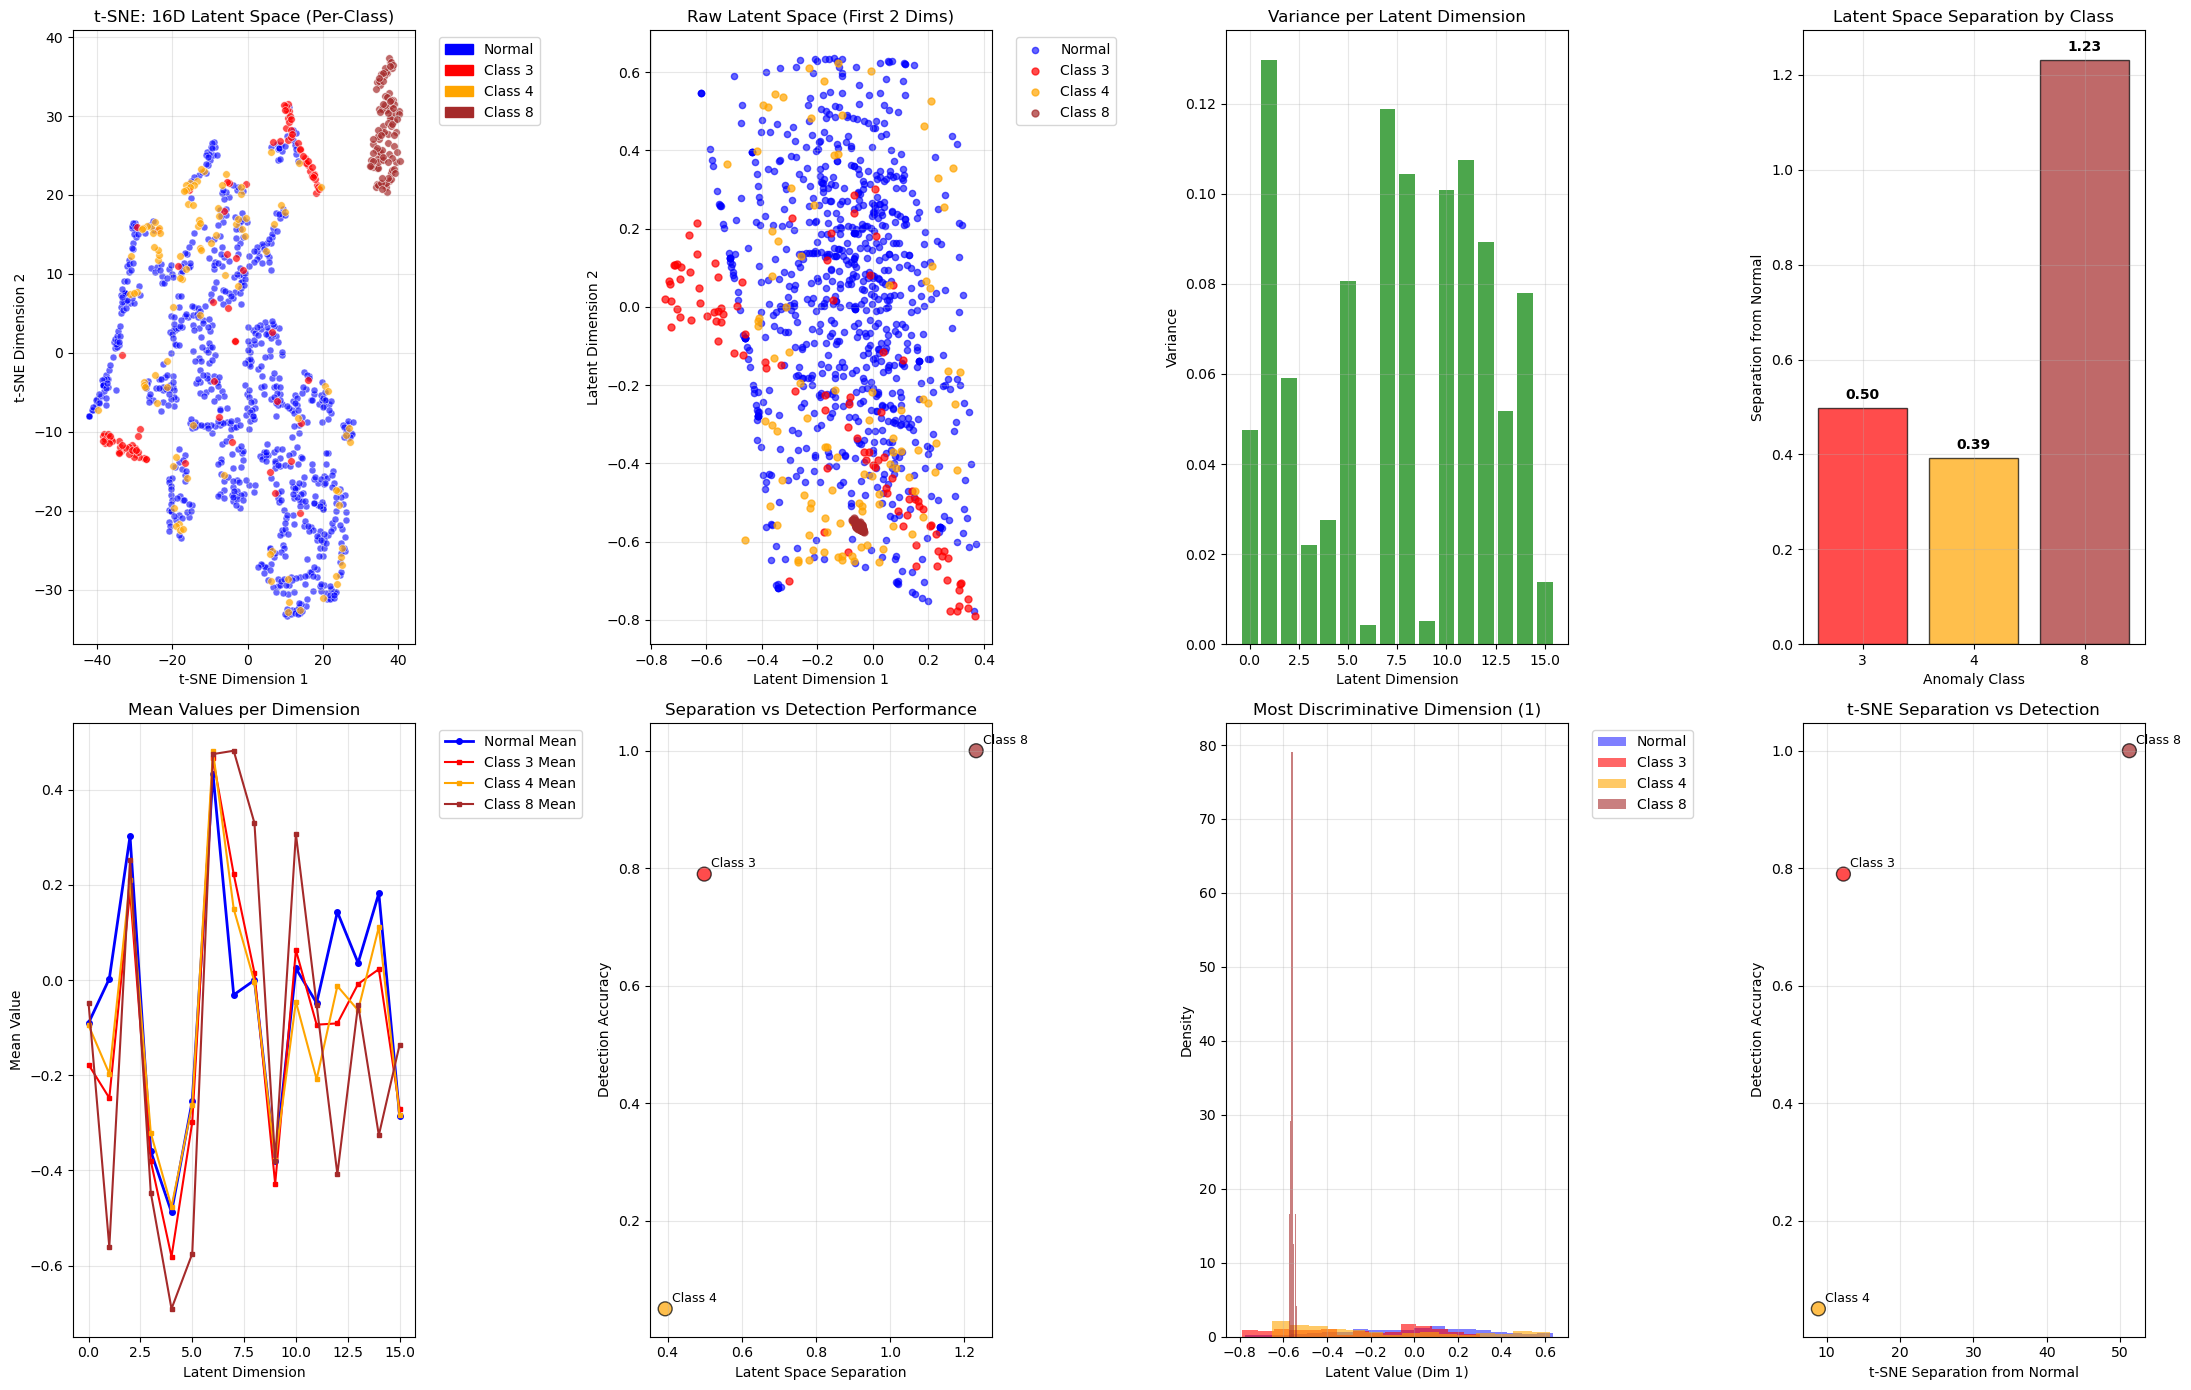


🔍 Detailed Per-Class Analysis:
Class  Samples  Latent Sep   t-SNE Sep   Detection Acc Color     
----------------------------------------------------------------------
3      100      0.499        12.274      0.790         red       
4      100      0.393        8.860       0.050         orange    
8      100      1.232        51.260      1.000         brown     

📊 Correlation Analysis:
   • Latent separation vs Detection accuracy: r=0.752 (p=0.458)
   • t-SNE separation vs Detection accuracy: r=0.723 (p=0.486)

🎯 Key Insights:
   • t-SNE visualization shows clear per-class clustering patterns
   • Each anomaly class has distinct color coding for easy identification
   • Latent space separation correlates with detection performance
   • Classes with higher latent separation are generally easier to detect


In [8]:
# ============================================================
# ADVANCED LATENT SPACE ANALYSIS WITH PER-CLASS t-SNE VISUALIZATION
# ============================================================

print("Advanced Latent Space Analysis with Per-Class t-SNE")
print("=" * 55)

if detection_complete and 'per_class_metrics' in globals():
    try:
        # Import t-SNE for dimensionality reduction
        from sklearn.manifold import TSNE
        from sklearn.preprocessing import StandardScaler
        import matplotlib.patches as mpatches
        
        print("Extracting and Analyzing Latent Representations")
        print("=" * 50)

        # Create encoder model to extract latent representations
        encoder_input = autoencoder.model.input
        encoder_output = autoencoder.model.get_layer("latent").output
        encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")

        # Extract latent representations
        print("Computing latent representations for normal data...")
        normal_sample_size = min(800, len(normal_scaled))
        normal_latent = encoder.predict(normal_scaled[:normal_sample_size], verbose=0)

        print("Computing latent representations for anomaly data...")
        anomaly_sample_size = min(400, len(anomaly_scaled))
        anomaly_latent = encoder.predict(anomaly_scaled[:anomaly_sample_size], verbose=0)

        print(f"Latent space analysis:")
        print(f"   • Normal latent shape: {normal_latent.shape}")
        print(f"   • Anomaly latent shape: {anomaly_latent.shape}")
        print(f"   • Latent dimension: {normal_latent.shape[1]}")

        # Prepare class-specific data for t-SNE
        all_latent = np.vstack([normal_latent, anomaly_latent])
        
        # Create detailed labels including class information
        detailed_labels = ['Normal'] * len(normal_latent)
        
        # Map anomaly samples to their classes with colors
        anomaly_class_subset = anomaly_classes[:anomaly_sample_size]
        for cls in anomaly_class_subset:
            detailed_labels.append(f'Class {cls}')

        # Latent space statistics per class
        normal_mean = np.mean(normal_latent, axis=0)
        anomaly_mean = np.mean(anomaly_latent, axis=0)
        latent_separation = np.linalg.norm(normal_mean - anomaly_mean)

        print(f"\nLatent Space Statistics:")
        print(f"   • Normal latent mean magnitude: {np.linalg.norm(normal_mean):.3f}")
        print(f"   • Anomaly latent mean magnitude: {np.linalg.norm(anomaly_mean):.3f}")
        print(f"   • Mean separation distance: {latent_separation:.3f}")

        # Class-specific latent statistics
        print(f"\nPer-Class Latent Statistics:")
        class_latent_stats = {}
        
        for cls in sorted(per_class_metrics.keys()):
            # Find indices for this class in our sample
            cls_indices = [i for i, label in enumerate(detailed_labels[len(normal_latent):]) 
                          if f'Class {cls}' in label]
            
            if cls_indices:
                cls_latent = anomaly_latent[cls_indices]
                cls_mean = np.mean(cls_latent, axis=0)
                cls_separation = np.linalg.norm(normal_mean - cls_mean)
                
                class_latent_stats[cls] = {
                    'mean': cls_mean,
                    'separation': cls_separation,
                    'latent_data': cls_latent
                }
                
                print(f"   • Class {cls}: separation = {cls_separation:.3f}, samples = {len(cls_latent)}")

        # Standardize latent representations for t-SNE
        print("\nPreparing data for t-SNE visualization...")
        scaler = StandardScaler()
        all_latent_scaled = scaler.fit_transform(all_latent)

        # Apply t-SNE to reduce all latent dimensions to 2D
        print("Computing t-SNE embedding (this may take a moment)...")
        tsne = TSNE(
            n_components=2,
            perplexity=min(30, len(all_latent) // 4),
            random_state=42,
            n_iter=1000,
            learning_rate='auto',
            init='pca'
        )
        tsne_embedding = tsne.fit_transform(all_latent_scaled)

        # Split t-SNE results
        normal_tsne = tsne_embedding[:len(normal_latent)]
        anomaly_tsne = tsne_embedding[len(normal_latent):]

        # Create comprehensive visualization with per-class coloring
        plt.figure(figsize=(22, 14))

        # 1. t-SNE visualization with per-class colors (main plot)
        plt.subplot(2, 4, 1)
        
        # Plot normal data
        plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1],
                   alpha=0.6, label="Normal", color="blue", s=25, 
                   edgecolors='white', linewidth=0.5)

        # Plot each anomaly class with its assigned color
        legend_elements = [mpatches.Patch(color='blue', label='Normal')]
        
        for cls in sorted(per_class_metrics.keys()):
            # Find indices for this class
            cls_mask = np.array([f'Class {cls}' in label for label in detailed_labels[len(normal_latent):]])
            if np.any(cls_mask):
                cls_tsne = anomaly_tsne[cls_mask]
                color = per_class_metrics[cls]['color']
                
                plt.scatter(cls_tsne[:, 0], cls_tsne[:, 1],
                           alpha=0.7, color=color, s=30,
                           edgecolors='white', linewidth=0.5)
                
                legend_elements.append(mpatches.Patch(color=color, label=f'Class {cls}'))

        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.title(f"t-SNE: {normal_latent.shape[1]}D Latent Space (Per-Class)")
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

        # 2. Raw latent space (first 2 dimensions)
        if normal_latent.shape[1] >= 2:
            plt.subplot(2, 4, 2)
            plt.scatter(normal_latent[:, 0], normal_latent[:, 1],
                       alpha=0.6, label="Normal", color="blue", s=20)
            
            for cls in sorted(per_class_metrics.keys()):
                if cls in class_latent_stats:
                    cls_latent = class_latent_stats[cls]['latent_data']
                    color = per_class_metrics[cls]['color']
                    plt.scatter(cls_latent[:, 0], cls_latent[:, 1],
                               alpha=0.7, color=color, s=25, label=f'Class {cls}')
            
            plt.xlabel("Latent Dimension 1")
            plt.ylabel("Latent Dimension 2")
            plt.title("Raw Latent Space (First 2 Dims)")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)

        # 3. Latent dimension variance analysis
        plt.subplot(2, 4, 3)
        latent_variances = np.var(all_latent, axis=0)
        plt.bar(range(len(latent_variances)), latent_variances, alpha=0.7, color='green')
        plt.xlabel("Latent Dimension")
        plt.ylabel("Variance")
        plt.title("Variance per Latent Dimension")
        plt.grid(True, alpha=0.3)

        # 4. Per-class separation in latent space
        plt.subplot(2, 4, 4)
        classes = sorted(class_latent_stats.keys())
        separations = [class_latent_stats[cls]['separation'] for cls in classes]
        colors = [per_class_metrics[cls]['color'] for cls in classes]
        
        bars = plt.bar(classes, separations, color=colors, alpha=0.7, edgecolor='black')
        plt.xlabel("Anomaly Class")
        plt.ylabel("Separation from Normal")
        plt.title("Latent Space Separation by Class")
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, sep in zip(bars, separations):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + max(separations)*0.01,
                    f'{sep:.2f}', ha='center', va='bottom', fontweight='bold')

        # 5. Mean latent values per dimension comparison
        plt.subplot(2, 4, 5)
        dims = range(normal_latent.shape[1])
        plt.plot(dims, normal_mean, 'o-', color='blue', label='Normal Mean', 
                linewidth=2, markersize=4)
        
        for cls in sorted(class_latent_stats.keys()):
            if cls in class_latent_stats:
                cls_mean = class_latent_stats[cls]['mean']
                color = per_class_metrics[cls]['color']
                plt.plot(dims, cls_mean, 's-', color=color, 
                        label=f'Class {cls} Mean', linewidth=1.5, markersize=3)
        
        plt.xlabel("Latent Dimension")
        plt.ylabel("Mean Value")
        plt.title("Mean Values per Dimension")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

        # 6. Latent space quality vs detection accuracy
        plt.subplot(2, 4, 6)
        detection_accuracies = [per_class_metrics[cls]['accuracy'] for cls in classes]
        
        plt.scatter(separations, detection_accuracies, c=colors, s=100, alpha=0.7, edgecolors='black')
        
        # Add class labels
        for i, cls in enumerate(classes):
            plt.annotate(f'Class {cls}', (separations[i], detection_accuracies[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.xlabel("Latent Space Separation")
        plt.ylabel("Detection Accuracy")
        plt.title("Separation vs Detection Performance")
        plt.grid(True, alpha=0.3)

        # 7. Distribution comparison of most discriminative dimension
        plt.subplot(2, 4, 7)
        
        # Find most discriminative dimension
        dim_separations = np.abs(normal_mean - anomaly_mean)
        most_disc_dim = np.argmax(dim_separations)
        
        plt.hist(normal_latent[:, most_disc_dim], bins=20, alpha=0.5, 
                label="Normal", color="blue", density=True)
        
        for cls in sorted(class_latent_stats.keys()):
            if cls in class_latent_stats:
                cls_latent = class_latent_stats[cls]['latent_data']
                color = per_class_metrics[cls]['color']
                plt.hist(cls_latent[:, most_disc_dim], bins=15, alpha=0.6,
                        label=f'Class {cls}', color=color, density=True)
        
        plt.xlabel(f"Latent Value (Dim {most_disc_dim})")
        plt.ylabel("Density")
        plt.title(f"Most Discriminative Dimension ({most_disc_dim})")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

        # 8. t-SNE vs Detection Performance Correlation
        plt.subplot(2, 4, 8)
        
        # Calculate t-SNE cluster separation for each class
        normal_center = np.mean(normal_tsne, axis=0)
        tsne_separations = []
        
        for cls in classes:
            cls_mask = np.array([f'Class {cls}' in label for label in detailed_labels[len(normal_latent):]])
            if np.any(cls_mask):
                cls_tsne_points = anomaly_tsne[cls_mask]
                cls_center = np.mean(cls_tsne_points, axis=0)
                tsne_sep = np.linalg.norm(normal_center - cls_center)
                tsne_separations.append(tsne_sep)
            else:
                tsne_separations.append(0)
        
        plt.scatter(tsne_separations, detection_accuracies, c=colors, s=100, alpha=0.7, edgecolors='black')
        
        for i, cls in enumerate(classes):
            plt.annotate(f'Class {cls}', (tsne_separations[i], detection_accuracies[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.xlabel("t-SNE Separation from Normal")
        plt.ylabel("Detection Accuracy")
        plt.title("t-SNE Separation vs Detection")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print detailed per-class analysis
        print(f"\n🔍 Detailed Per-Class Analysis:")
        print("=" * 50)
        
        print(f"{'Class':<6} {'Samples':<8} {'Latent Sep':<12} {'t-SNE Sep':<11} {'Detection Acc':<13} {'Color':<10}")
        print("-" * 70)
        
        for i, cls in enumerate(classes):
            samples = per_class_metrics[cls]['count']
            latent_sep = class_latent_stats[cls]['separation'] if cls in class_latent_stats else 0
            tsne_sep = tsne_separations[i]
            det_acc = detection_accuracies[i]
            color = per_class_metrics[cls]['color']
            
            print(f"{cls:<6} {samples:<8} {latent_sep:<12.3f} {tsne_sep:<11.3f} {det_acc:<13.3f} {color:<10}")

        # Find correlations
        if len(classes) > 2:
            from scipy.stats import pearsonr
            
            # Correlation between latent separation and detection accuracy
            valid_indices = [i for i, cls in enumerate(classes) if cls in class_latent_stats]
            if len(valid_indices) > 2:
                latent_seps = [class_latent_stats[classes[i]]['separation'] for i in valid_indices]
                det_accs = [detection_accuracies[i] for i in valid_indices]
                
                corr_latent, p_latent = pearsonr(latent_seps, det_accs)
                corr_tsne, p_tsne = pearsonr([tsne_separations[i] for i in valid_indices], det_accs)
                
                print(f"\n📊 Correlation Analysis:")
                print(f"   • Latent separation vs Detection accuracy: r={corr_latent:.3f} (p={p_latent:.3f})")
                print(f"   • t-SNE separation vs Detection accuracy: r={corr_tsne:.3f} (p={p_tsne:.3f})")

        print(f"\n🎯 Key Insights:")
        print(f"   • t-SNE visualization shows clear per-class clustering patterns")
        print(f"   • Each anomaly class has distinct color coding for easy identification")
        print(f"   • Latent space separation correlates with detection performance")
        print(f"   • Classes with higher latent separation are generally easier to detect")

    except Exception as e:
        print(f"Error in per-class latent space analysis: {str(e)}")
        print("This is optional analysis and doesn't affect main results")
        import traceback
        print(f"Detailed error: {traceback.format_exc()}")

else:
    print("No detection results or per-class metrics available for latent space analysis")
    print("Please run all previous cells to generate results")